# Measuring and Removing a Rotation Period Signal from a *Kepler* Light Curve

## Learning Goals
By the end of this tutorial, you will:

- Learn what the light curve and periodogram of a rotating star looks like.
- Be able to estimate a rotation period using a Lomb-Scargle periodogram.
- Be able to use the Lomb-Scargle method to model and remove the rotation signal.
- Understand how *iterative sine fitting* works.


## Introduction

A light curve from a star often has many oscillating signals. For some people, this is useful data, and for others this is annoying noise. In this tutorial, we will look at how a Lomb-Scargle periodogram can be used to extract models of sinusoidal variation from light curves, and how those can be used to detect and remove signals.

If you find this tutorial difficult to follow, we recommend consulting the companion tutorials, which explain the basics of *Kepler* light curves and periodograms.

## Imports
This tutorial only requires **[Lightkurve](https://docs.lightkurve.org)** and **[NumPy](https://numpy.org/)**.

In [1]:
import lightkurve as lk
import numpy as np
%matplotlib inline

## 1. What are Rotation Signals?

Many different types of stars exhibit oscillations in their brightnesses over time. By studying these changes in brightness, we can derive interesting properties from these stars. One example of such a property is a star's rotation rate.

For stars like the Sun, magnetic activity on their surface will cause [star spots](https://en.wikipedia.org/wiki/Sunspot) to appear. These are areas of the star that are temporarily cooler, and therefore appear darker, than the surrounding regions. As these spots rotate in and out of our view, the star's brightness will increase and decrease. This is often referred to as a *rotation signal*.

A periodogram will show this brightness oscillation as a peak in the frequency domain. In what follows, we will look at how to extract this periodic frequency from the periodogram using Lightkurve's tools.

## 2. Plotting the Light Curve of a Rotating Star

In an accompanying tutorial, we looked at an eclipsing binary system, in which two stars eclipsed each other periodically. Now, let's look at a different kind of oscillator — a rotating star — and see how that signal appears in the time series brightness data.

We're going to explore a star named KIC 2157356, which is part of the cohort of rotating stars that were studied by *Kepler* and analyzed in a research paper by [McQuillan et al. (2014)](https://arxiv.org/abs/1402.5694).

Because rotation variability tends to happen on relatively long time scales (for instance, the Sun rotates every 25 days), we will start by downloading three ~90-day long quarters of *Kepler* data and then combine them using Lightkurve's [`stitch()`](https://docs.lightkurve.org/api/lightkurve.collections.LightCurveCollection.html#lightkurve.collections.LightCurveCollection.stitch) feature.

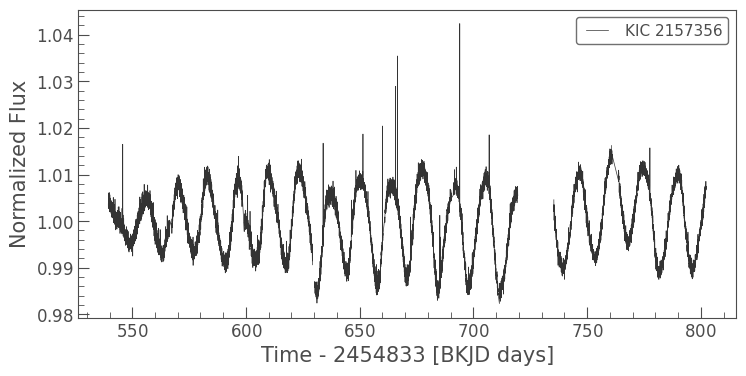

In [2]:
# Search Kepler data for Quarters 6, 7, and 8.
search_result = lk.search_lightcurve('KIC 2157356', mission='Kepler', quarter=(6, 7, 8))
# Download and stitch the data together
lc = search_result.download_all().stitch()
# Plot the resulting light curve
lc.plot();

This looks quite different from the light curve we studied in the eclipsing binary tutorial. Here, the brightness modulation from the spots rotating in and out of view is significantly larger, with an overall $2\%$ change in the brightness of the star! Compare this with asteroseismic oscillations (see the accompanying tutorials), which occur on the parts per million scale instead. (Note: 1 part per million equals 0.0001%).

## 3. Plotting the Periodogram of a Rotating Star

Next, we'll convert the light curve to the frequency domain. Based on the plot we created above, we expect to see a high-power peak associated with the rotation period. We may also expect to see some smaller peaks, such as alias harmonics.

For clarity, we will truncate the periodogram to `maximum_period=100`, because we can infer from the light curve that the rotation period is much shorter than that. We also set `view=period` to make sure the x-axis uses period rather than frequency units. This is helpful because it is more natural to think about rotation rates in units of *days* rather than *Hertz* (1/s).

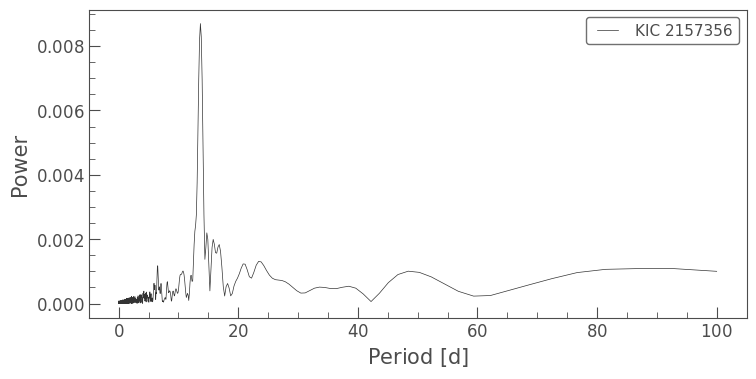

In [3]:
pg = lc.to_periodogram(maximum_period=100)
pg.plot(view='period');

Here we can see a strong peak near 13 days, which is consistent with the sinusoidal trend we saw in the time-domain plot earlier. The reason there are so few aliases in this periodogram is most likely because the star we've chosen has a variability that is very close to sinusoidal, which is not always the case.

To obtain an estimate of the rotation period, we can now access the `period_at_max_power` property:

In [4]:
pg.period_at_max_power

<Quantity 13.67086523 d>

Success!  We established that the highest peak in the periodogram appears to align with the expected rotation signal in our time series, and we used a periodogram to obtain an estimate of the rotation period.

Next, we will use additional features of the Lomb-Scargle periodogram to model the rotational signal in the time domain.

## 4. Using the Lomb-Scargle Method to Model the Rotation Signal

Lightkurve uses the Lomb-Scargle method to make periodograms. For more information on Lomb-Scargle periodograms, read [Vanderplas (2017)](https://arxiv.org/pdf/1703.09824.pdf). Without delving into the fine details here, Lomb-Scargle works by fitting a sinusoidal curve at each of the frequencies in the periodogram, and uses this fit to determine the value of power each frequency has in the periodogram. These model fits are stored in the periodogram object and can be extracted.

In the graph below, we visualize the Lomb-Scargle model associated with the highest peak by extracting it and then plotting it on top of our time series data. We need to pass in the `time` range we want the model for, as well as the specific `frequency` for which we want the model returned.

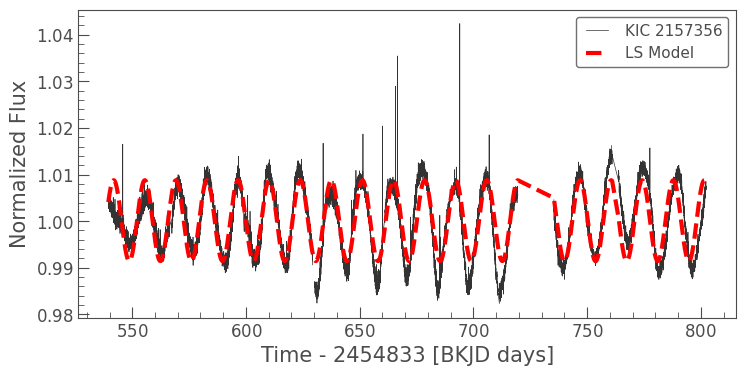

In [5]:
# Create a model light curve for the highest peak in the periodogram
lc_model = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
# Plot the light curve
ax = lc.plot()
# Plot the model light curve on top
lc_model.plot(ax=ax, lw=3, ls='--', c='red');

Looking at the plot above, we can see that the Lomb-Scargle model fits the rotation signal relatively well. This is expected; it corresponds to the highest peak in the periodogram, after all. It is not perfect, however. There are deviations in amplitude, and also in phase towards the right hand side of the graph.

The periodogram will only ever be able to approximate the exact oscillation frequency, and there will always be some associated error (in fact if you look at the periodogram higher up, you'll see that the peak is relatively broad). This uncertainty reflects the fact that the rotation signal is *not* a perfect sinusoid, and that there is additional noise from the star to deal with on top of that. It's for this reason that studies of stellar rotation often use multiple independent methods to estimate a rotation period.

## 5. Removing Periodic Signals Using Iterative Sine Fitting

We're not always interested in the rotation signal — sometimes, we want it removed! This is the case, for example, when studying the small signals of a transiting planet in a star which also shows a strong rotation signal. Using the tools we described above, we can model and remove the rotation signal from the time series to help us study the planet transits.

This process, called *iterative sine fitting*, has a limited range of applications, but is useful to know for quick analysis. Let's apply it to KIC 8197761, a star known to host a planet embedded within stellar noise.

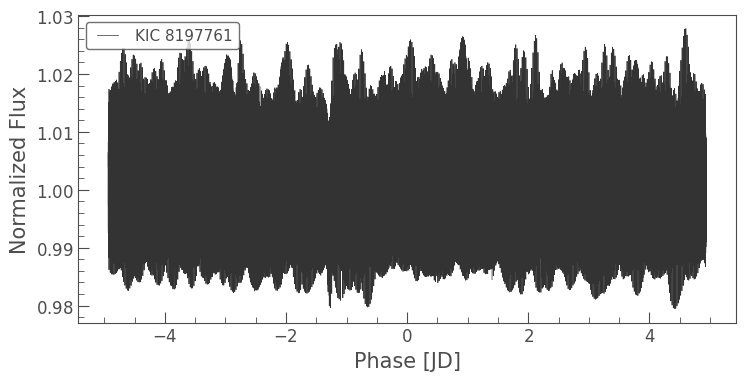

In [6]:
# Download the light curve data
search = lk.search_lightcurve('KIC 8197761', mission='Kepler')
lc = search.download_all().stitch()

# Fold the light curve at the known planet period
planet_period = 9.8686667
lc.fold(period=planet_period).plot();

Despite these data being folded on the period of a known planet, we are unable to see the planet transits within the noise. Let's have a look at the periodogram.

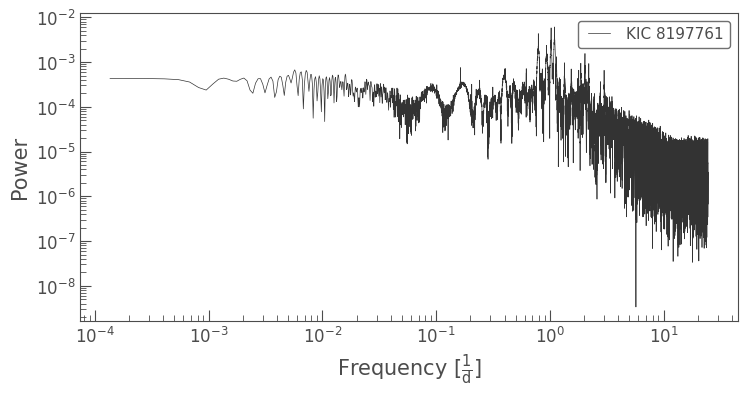

In [7]:
pg = lc.to_periodogram()
pg.plot(scale='log');

As we can see in this periodogram, the star appears to include multiple high-amplitude oscillation signals. Using the Lomb-Scargle `model()` method we used earlier, we can remove these signals from the time series data. We'll do this as follows:

1. Calculate a periodogram.
2. Calculate the Lomb-Scargle `model()` for the highest peak.
3. Divide the light curve by the model to remove the signal.
4. Repeat using the new light curve.

In this example, we will apply this procedure 50 times, that is, we're going to remove the signals associated with the 50 highest peaks in the periodogram from the time series.

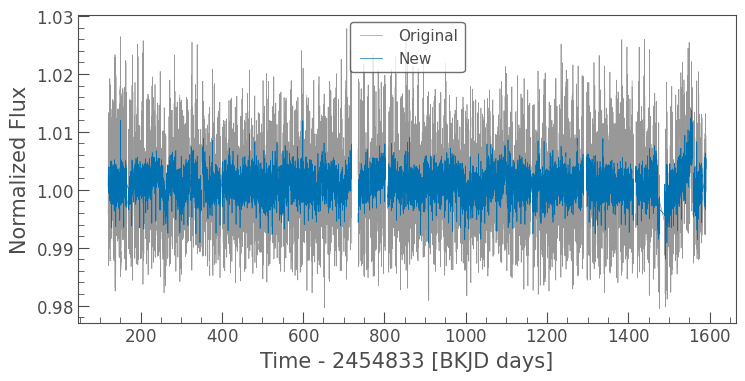

In [8]:
# Remove the signals associated with the 50 highest peaks
newlc = lc.copy()
for i in range(50):
  pg = newlc.to_periodogram()
  model = pg.model(time=newlc.time, frequency=pg.frequency_at_max_power)
  newlc.flux = newlc.flux / model.flux

# Plot the new light curve on top of the original one
ax = lc.plot(alpha=.5, label='Original');
newlc.plot(ax=ax, label='New'); 

In the graph above, we can observe that the new light curve displays less variations. Let's go ahead and fold it to find out if we can see the planet transit this time around. We'll also plot a binned version of our reduced light curve on top, just to make things clearer.

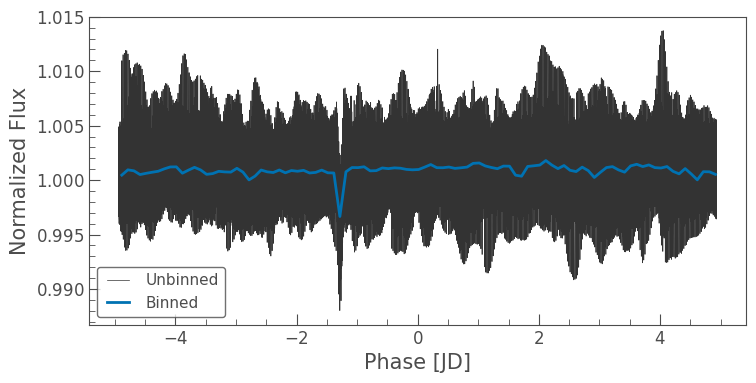

In [9]:
ax = newlc.fold(period=planet_period).plot(label='Unbinned')
newlc.fold(period=planet_period).bin(0.1).plot(ax=ax, lw=2, label='Binned');

Now we can see that a "dip" consistent with a planet transit has appeared, which makes it clearer to study!

It is important to note here that iterative sine fitting, as used in this tutorial, is a pragmatic method with a few drawbacks. The most important drawback is that the 50 signals we have attempted to remove were probably not perfectly sinusoidal in shape. This means that we have likely introduced complicated new residual patterns into the light curve, and introduced spurious new peaks in the periodogram. It is important to be very careful when using light curves to which complicated and imperfect data manipulation operations have been applied.

For new developments on how to extract rotation using advanced methods such as Gaussian Processes or asteroseismology, read, for example, [Angus et al. (2017)](https://arxiv.org/abs/1706.05459) and [Davies et al. (2015)](https://arxiv.org/abs/1411.1359).

## About this Notebook

**Authors**: Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-15

# Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [10]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>